# Clinical-Trial Survival Analysis for Treatment Efficacy

# Problem Statement

This project aims to evaluate the efficacy of different treatments in a clinical trial by analyzing patient survival times. Using survival analysis techniques like Kaplan-Meier curves and the Cox Proportional Hazards model, the study will identify which treatment offers better survival outcomes while accounting for censored data and patient-specific factors.

In [ ]:
!pip install lifelines --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 6.7 MB/s eta 0:00:00


# Lifelines:
lifelines is a special library used for survival analysis — a type of analysis used in medical research to study how long something lasts (like how long patients survive, or how long until a disease returns).

It has tools for Kaplan–Meier curves, Cox models, log-rank tests, and more.

Kaplan-Meier estimation

Cox Proportional Hazards model

Log-rank tests

Parametric models (Weibull, Exponential, etc.)

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [ ]:
# Load dataset
df = pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')

In [ ]:
df

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no
...,...,...,...,...,...,...,...,...,...
269,135,231,1,test,large,70,18,67,yes
270,136,0,0,test,large,80,4,65,no
271,136,378,1,test,large,80,4,65,no
272,137,0,0,test,large,30,3,37,no


In [ ]:
df.head()
df.tail()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


(274, 9)

In [ ]:
df.describe()

,ID,TIME,Y,karno,diagtime,age
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,69.000000,60.813869,0.467153,58.569343,8.773723,58.306569
std,39.619805,126.961872,0.499833,20.002855,10.592687,10.522303
min,1.000000,0.000000,0.000000,10.000000,1.000000,34.000000
25%,35.000000,0.000000,0.000000,40.000000,3.000000,51.000000
50%,69.000000,0.500000,0.000000,60.000000,5.000000,62.000000
75%,103.000000,78.250000,1.000000,75.000000,11.000000,66.000000
max,137.000000,999.000000,1.000000,99.000000,87.000000,81.000000


# Kaplan-Meier Estimator
how likely is something to survive (or continue) over time

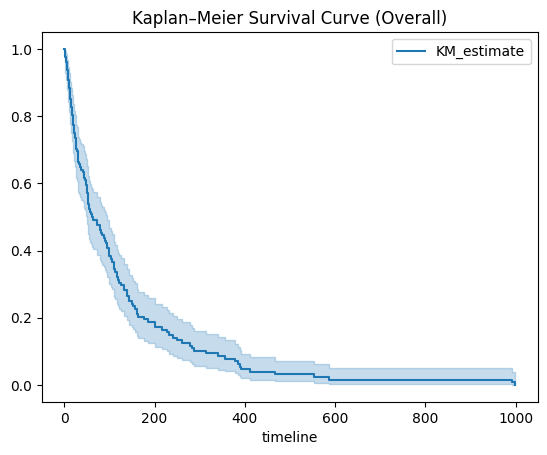

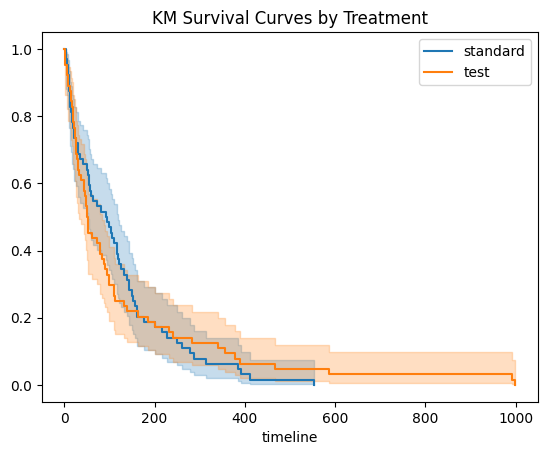

In [ ]:
# Separate first and second rows per patient: Y=1 is death, Y=0 is start or censoring
df_event = df[df['Y'] == 1]

kmf = KaplanMeierFitter()

# Example: overall KM curve
kmf.fit(durations=df_event['TIME'], event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Kaplan–Meier Survival Curve (Overall)')
plt.show()

# Example by treatment group
for trt_group in df_event['trt'].unique():
    mask = df_event['trt'] == trt_group
    kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
    kmf.plot_survival_function()

plt.title('KM Survival Curves by Treatment')
plt.show()

In [ ]:
# Median survival time
for trt_group in df_event['trt'].unique():
    mask = df_event['trt'] == trt_group
    kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
    print(f"Median survival for treatment {trt_group}: {kmf.median_survival_time_}")

Median survival for treatment standard: 95.0
Median survival for treatment test: 52.0


/tmp/ipython-input-9-3087372828.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
/tmp/ipython-input-9-3087372828.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
/tmp/ipython-input-9-3087372828.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
/tmp/ipython-input-9-3087372828.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))


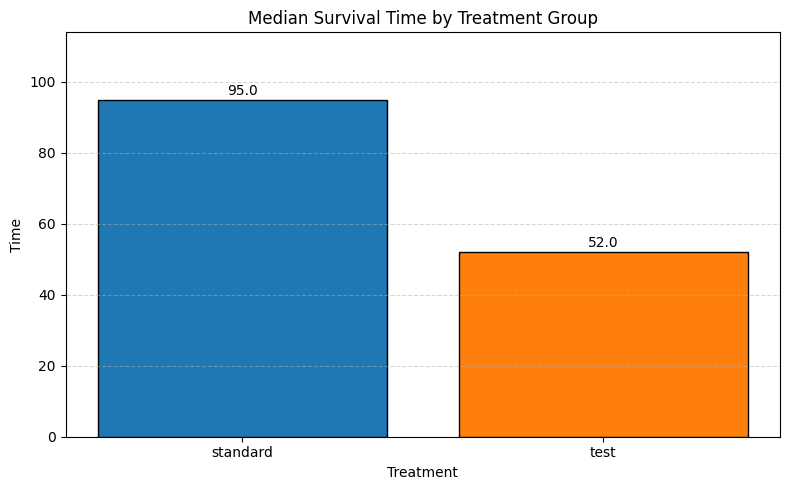

In [ ]:
# Use full dataset, not just df_event (include censored data too)
kmf = KaplanMeierFitter()
median_data = []

# Compute median survival times for each treatment group
for trt_group in df['trt'].unique():
    mask = df['trt'] == trt_group
    kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
    median_time = kmf.median_survival_time_
    median_data.append({'Treatment': str(trt_group), 'Median Survival Time': median_time})

# Convert to DataFrame
df_medians = pd.DataFrame(median_data)
df_medians['Median Survival Time'] = df_medians['Median Survival Time'].replace(float('inf'), pd.NA)

# Define a color list (you can modify or extend this)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Add more if needed

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(df_medians['Treatment'], df_medians['Median Survival Time'],
               color=colors[:len(df_medians)], edgecolor='black')

# Annotate bars
for bar, value in zip(bars, df_medians['Median Survival Time']):
    label = f"{value:.1f}" if pd.notna(value) else "Not reached"
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, label,
             ha='center', va='bottom', fontsize=10)

plt.title("Median Survival Time by Treatment Group")
plt.ylabel("Time")
plt.xlabel("Treatment")
plt.ylim(0, df_medians['Median Survival Time'].dropna().max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
from lifelines.statistics import logrank_test

group1 = df_event[df_event['trt'] == 'standard']
group2 = df_event[df_event['trt'] == 'test']

results = logrank_test(group1['TIME'], group2['TIME'], event_observed_A=group1['Y'], event_observed_B=group2['Y'])
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


In [ ]:
from lifelines.statistics import logrank_test

# Assuming 'trt' contains treatment labels as strings: 'standard' and 'test'
group1 = df_event[df_event['trt'] == 'standard']
group2 = df_event[df_event['trt'] == 'test']

# Perform log-rank test
results = logrank_test(
    group1['TIME'], group2['TIME'],
    event_observed_A=group1['Y'], event_observed_B=group2['Y']
)

# Display summary
print(results.summary)

# Extract and print p-value with interpretation
p = results.p_value
print(f"Log-Rank Test p-value: {p:.5f}")

if p < 0.05:
    print("There is strong evidence that survival differs between the two treatment groups (p < 0.05).")
else:
    print("There is no strong evidence that survival differs between the two treatment groups (p ≥ 0.05).")


   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371
Log-Rank Test p-value: 0.91423
There is no strong evidence that survival differs between the two treatment groups (p ≥ 0.05).


<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-06-30 16:36:52 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

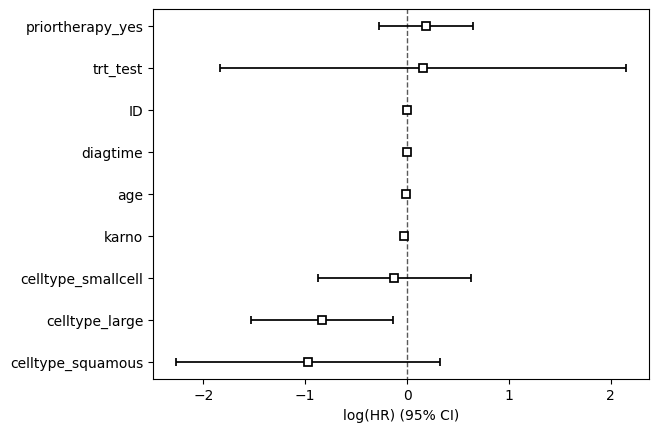

In [ ]:
from lifelines import CoxPHFitter

# Prepare wide-format data: one row per subject
df_wide = df_event.copy()

# Encode categorical variables
df_wide = pd.get_dummies(df_wide, columns=['trt', 'celltype', 'priortherapy'], drop_first=True)

cph = CoxPHFitter()
cph.fit(df_wide, duration_col='TIME', event_col='Y')
cph.print_summary()
cph.plot()
plt.show()

In [ ]:
# Step 1: Separate rows by Y
df_start = df[df["Y"] == 0].copy()   # Start of observation/censoring
df_event = df[df["Y"] == 1].copy()   # Death

# Step 2: Merge on ID
# Bring over TIME as stop and Y as event
df_event = df_event.rename(columns={"TIME": "stop", "Y": "event"})
df_start = df_start.rename(columns={"TIME": "start"})

df_timevarying = pd.merge(
    df_start,
    df_event[["ID", "stop", "event"]],
    on="ID"
)

# Step 3: One-hot encode categorical variables
df_timevarying = pd.get_dummies(df_timevarying, columns=["trt", "celltype", "priortherapy"], drop_first=True)

# Final check
print(df_timevarying[['ID', 'start', 'stop', 'event']].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1


In [ ]:
import numpy as np
# Check for NaNs
print("Any NaNs?", df_timevarying.isnull().values.any())

# Check for infinite values
print("Any Infs?", np.isinf(df_timevarying.select_dtypes(include=[np.number])).values.any())

Any NaNs? False
Any Infs? False


In [ ]:
print(df_timevarying[df_timevarying.isnull().any(axis=1)])
print(df_timevarying[np.isinf(df_timevarying.select_dtypes(include=[np.number]).any(axis=1))])

Empty DataFrame
Columns: [ID, start, Y, karno, diagtime, age, stop, event, trt_test, celltype_large, celltype_smallcell, celltype_squamous, priortherapy_yes]
Index: []
Empty DataFrame
Columns: [ID, start, Y, karno, diagtime, age, stop, event, trt_test, celltype_large, celltype_smallcell, celltype_squamous, priortherapy_yes]
Index: []


In [ ]:
if 'Y' in df_timevarying.columns:
    df_timevarying.drop(columns=['Y'], inplace=True)

<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-06-30 16:36:53 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

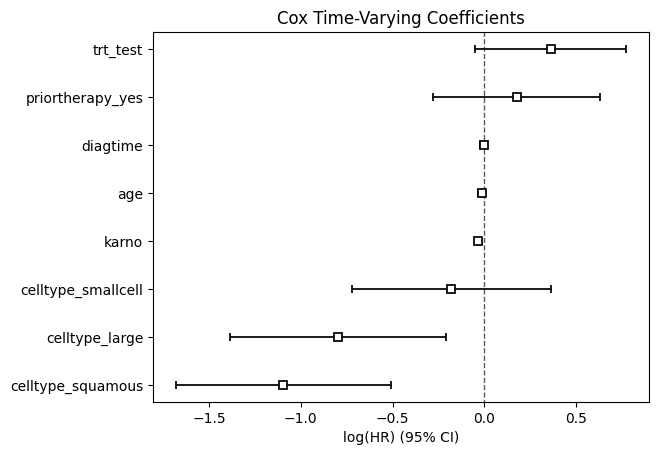

In [ ]:
from lifelines import CoxTimeVaryingFitter

# Initialize the Cox time-varying model
ctv = CoxTimeVaryingFitter()

# Fit the model using the transformed dataframe
ctv.fit(
    df_timevarying,
    id_col='ID',
    start_col='start',
    stop_col='stop',
    event_col='event'  # This reflects the renamed column
)
# Print model summary
ctv.print_summary()

# Plot coefficients
ctv.plot()
plt.title("Cox Time-Varying Coefficients")
plt.show()

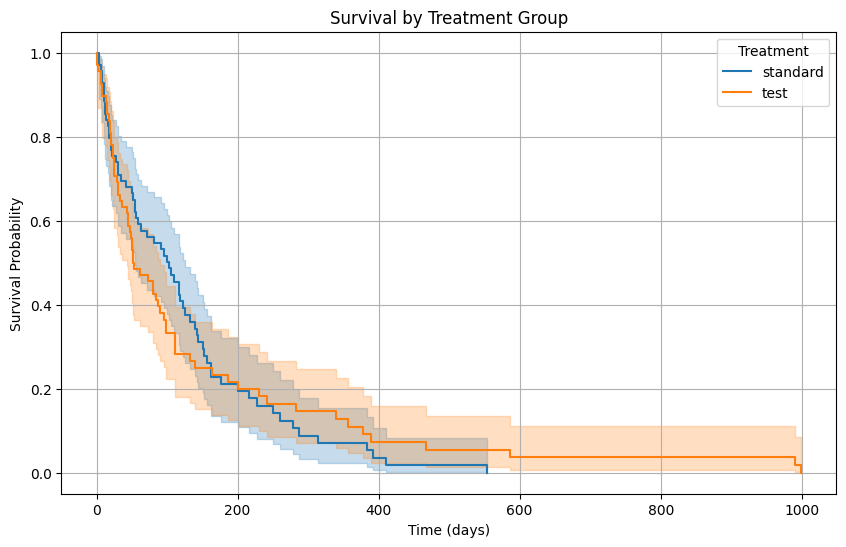

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for group in df['trt'].unique():
    label = str(group)
    mask = df['trt'] == group
    kmf.fit(df[mask]['TIME'], event_observed=df[mask]['Y'], label=label)
    kmf.plot_survival_function()

plt.title('Survival by Treatment Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title="Treatment")
plt.show()

In [ ]:
print(df['trt'].value_counts())

trt
standard    138
test        136
Name: count, dtype: int64


In [ ]:
from lifelines.statistics import logrank_test

# Assuming 'trt' column has two treatment types (e.g., 1 = Standard, 2 = Test)
group1 = df[df['trt'] == 'standard']
group2 = df[df['trt'] == 'test']

# Perform the log-rank test using correct event column: 'Y'
results = logrank_test(
    group1['TIME'], group2['TIME'],
    event_observed_A=group1['Y'],
    event_observed_B=group2['Y']
)

# Output
print(f"Log-Rank Test p-value: {results.p_value:.4f}")
if results.p_value < 0.05:
  print("→ Significant difference in survival.")
else:
    print("→ No statistically significant difference.")

Log-Rank Test p-value: 0.9277
→ No statistically significant difference.


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['celltype', 'trt', 'priortherapy'], drop_first=True)

# Collect celltype dummy variables
celltype_dummies = [col for col in df_encoded.columns if col.startswith('celltype_')]
treatment_dummies = [col for col in df_encoded.columns if col.startswith('treatment_')]
prior_dummies = [col for col in df_encoded.columns if col.startswith('prior_')]
# Define final feature set
features = ['TIME', 'Y', 'age', 'karno', 'diagtime'] + celltype_dummies + treatment_dummies + prior_dummies

# Prepare dataset
cox_df = df_encoded[features]

# Fit Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='TIME', event_col='Y')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 274 total observations, 146 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 274
number of events observed = 128
   partial log-likelihood = -475.48
         time fit was run = 2025-06-30 16:36:54 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
age                -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
karno              -0.03      0.97      0.01           -0.04           -0.02                0.96                0.98
diagtime            0.00      1.00      0.01           -0.01            0.02                0.99                1.02
celltype_large     -0.86      0.42      0.30           -1.44           -0.28                0.24                0.75
celltype_smallcell -0.46      0.63      0.26           -0.98            0.05                0.38                1.05
celltype_squamous  -1.18      0.31      0.30           -1.76           -0.60                0.17                0.55

                    cmp to     z      p  -log2(p)
covariate                                        
age                   0.00 -0.63   0.53      0.92
karno                 0.00 -5.86 <0.005     27.65
diagtime              0.00  0.37   0.71      0.49
celltype_large        0.00 -2.91 <0.005      8.13
celltype_smallcell    0.00 -1.78   0.07      3.74
celltype_squamous     0.00 -4.00 <0.005     13.97
---
Concordance = 0.74
Partial AIC = 962.96
log-likelihood ratio test = 59.94 on 6 df
-log2(p) of ll-ratio test = 34.33

| Column           | Description                                                                                 |
| ---------------- | ------------------------------------------------------------------------------------------- |
| *ID*           | Patient ID. Each patient has 2 rows: one for start (Y=0), one for death or censoring (Y=1). |
| *TIME*         | Time in days: start of study (if Y=0), death or censoring (if Y=1).                         |
| *Y*            | Event indicator: 0 = start/censoring, 1 = death.                                        |
| *trt*          | Treatment type: "standard" or "test".                                                   |
| *celltype*     | Type of lung cancer: e.g. "squamous", "smallcell", etc.                                 |
| *karno*        | Karnofsky score: patient’s overall health at start (higher = better).                       |
| *diagtime*     | Months from diagnosis to study entry.                                                       |
| *age*          | Age of the patient in years.                                                                |
| *priortherapy* | "yes" or "no" — whether the patient had therapy before this study.                      |

In [ ]:
def display_unique_values_and_counts(dataframe):
  for col in dataframe.columns:
    print(f"Column: {col}")
    print(dataframe[col].value_counts())
    print("-" * 30)

display_unique_values_and_counts(df)

Column: ID
ID
1      2
2      2
3      2
4      2
5      2
      ..
133    2
134    2
135    2
136    2
137    2
Name: count, Length: 137, dtype: int64
------------------------------
Column: TIME
TIME
0      137
8        4
25       4
51       3
52       3
      ... 
43       1
340      1
133      1
378      1
49       1
Name: count, Length: 102, dtype: int64
------------------------------
Column: Y
Y
0    146
1    128
Name: count, dtype: int64
------------------------------
Column: trt
trt
standard    138
test        136
Name: count, dtype: int64
------------------------------
Column: celltype
celltype
smallcell    96
squamous     70
adeno        54
large        54
Name: count, dtype: int64
------------------------------
Column: karno
karno
60    54
80    48
70    46
40    32
30    28
50    28
20    14
90    14
75     4
85     2
99     2
10     2
Name: count, dtype: int64
------------------------------
Column: diagtime
diagtime
4     38
2     38
3     36
5     28
11    14
12    14
8   

In [ ]:
print(df.head())
print("/n")
print(df.tail())
print("/n")
print(df.info())
print("/n")

   ID  TIME  Y       trt  celltype  karno  diagtime  age priortherapy
0   1     0  0  standard  squamous     60         7   69           no
1   1    72  1  standard  squamous     60         7   69           no
2   2     0  0  standard  squamous     70         5   64          yes
3   2   411  1  standard  squamous     70         5   64          yes
4   3     0  0  standard  squamous     60         3   38           no
/n
      ID  TIME  Y   trt celltype  karno  diagtime  age priortherapy
269  135   231  1  test    large     70        18   67          yes
270  136     0  0  test    large     80         4   65           no
271  136   378  1  test    large     80         4   65           no
272  137     0  0  test    large     30         3   37           no
273  137    49  1  test    large     30         3   37           no
/n
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        -